# Homework 3, Question 4: Reproduce the Monthly SST Anomalies Figure

In 2016 Dr. Chelle Gentemann and collaborators published a paper on the heat wave in the ocean off the California coast

The analysis was then performed using Matlab to process scientific data. To make Figure 1, here are the following steps:

- Download 4 TB of data from NASA PO.DAAC data archive via FTP
- Go through each day of data and subset to the West Coast Region to reduce size and save each subsetted day
- Go through 2002-2012 and create a daily climatology and save all 365 days of the climatology
- Go through each day of data and calculate the anomaly and save each day's anomaly

This whole process took about 1-2 month. Below we will do this using MUR SST data on AWS Open Data Program in a few minutes using Python.

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec
import matplotlib.pyplot as plt

import xarray as xr
xr.set_options(display_style="html")  # display dataset nicely

import warnings
warnings.simplefilter("ignore")  # filter some warning messages

# code features from https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
crs = ccrs.PlateCarree()  # set projection

Subset all the data to just the West Coast region

In [2]:
ds = xr.open_dataset("~/shared/climate-data/ds_hw.nc")
ds

<xarray.Dataset>
Dimensions:           (time: 6443, lat: 251, lon: 234)
Coordinates:
  * lat               (lat) float32 33.0 33.06 33.12 33.18 ... 47.88 47.94 48.0
  * lon               (lon) float32 -132.0 -131.9 -131.9 ... -118.1 -118.0
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2020-01-2...
Data variables:
    analysed_sst      (time, lat, lon) float32 ...
    analysis_error    (time, lat, lon) float32 ...
    mask              (time, lat, lon) float32 ...
    sea_ice_fraction  (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20200116T210000Z
    time_coverage_start:        20200115T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

In [3]:
# Data processing: 
# 1. Go through 2002-2012 and create a daily climatology and save all 365 days of the climatology
daily_climatology = ds.analysed_sst.sel(time = slice('2002', '2012')).groupby('time.dayofyear').mean()
daily_climatology
# 2. Go through each day of data and calculate the anomaly and save each day's anomaly
sst_anomolies = ds.analysed_sst.groupby('time.dayofyear') - daily_climatology

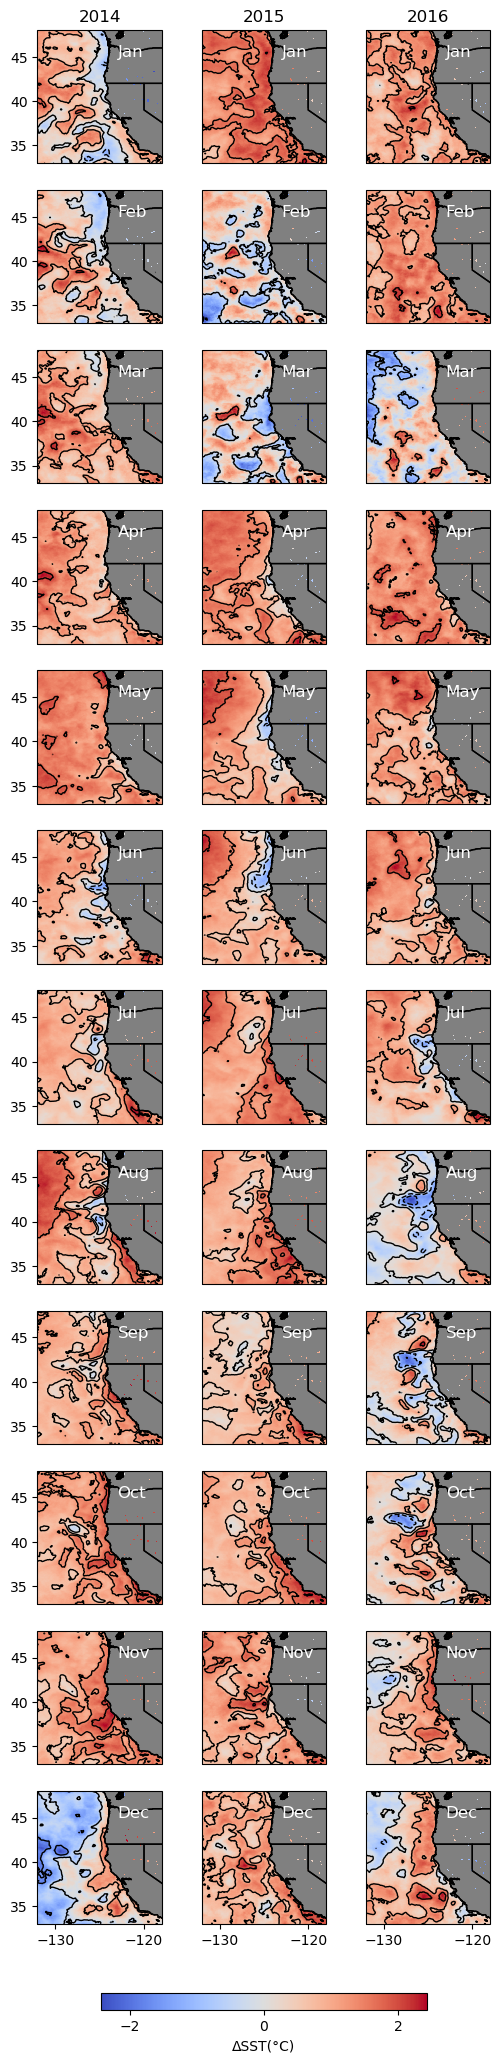

In [4]:
# An array for every month of the year
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# create the 12 * 3 grid for the graph.
fig, axs = plt.subplots(nrows=12, ncols=3, sharex=True, sharey=True, subplot_kw=dict(projection=crs),figsize=(6, 30))

## Plotting Data with a nested loop
for year in range(3):
    for month in range(12):
        time = f"20{14 + year}-{month + 1:02d}"
        
        # color map & plot the graphs
        img = sst_anomolies.sel(time=time).mean("time").plot(ax=axs[month, year], transform=crs, add_colorbar=False, cmap="coolwarm")

        # adding contour to each subplot
        sst_anomolies.sel(time=time).mean("time").plot.contour(ax=axs[month, year], colors='black', linewidths=1, vmin=-3, vmax=3)

        
        #ds.analysed_sst.sel(time=time).mean("time").plot(ax=ax[month, year], transform=crs)

        axs[month, year].coastlines("10m", color="k")
        axs[month, year].add_feature(cfeature.LAND, color="grey")
        axs[month, year].add_feature(cfeature.STATES.with_scale("10m"))
        axs[month, year].text(-123, 45, months[month], fontsize=12, color = 'white')
        axs[month, year].set_ylabel('')
        
        ## Add Month and Year label for each graph
        if month == 0:
            axs[month, year].set_title(f"20{14 + year}")
        if year == 0:
            axs[month, year].set_yticks([35, 40, 45])
        if month == 11:
            axs[month, year].set_xticks([-130, -120])
            axs[month, year].set_xlabel('')
            
# add color bar
colorBar = plt.colorbar(img, ax=axs, location='bottom', shrink=0.7, pad=0.03)
colorBar.set_label('ΔSST(°C)')
colorBar.set_ticks(range(-2, 3, 2))

plt.show()